In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
labels = ['Ulcer', 'Healthy']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=224

for label in labels:
    trainPath = os.path.join('/content/drive/My Drive/DFU Dataset/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

    testPath = os.path.join('/content/drive/My Drive/DFU Dataset/test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)

X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 110/110 [00:01<00:00, 73.21it/s]


In [4]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=1010)

X_test, Y_test = shuffle(X_test, Y_test, random_state=1010)
X_test.shape

(211, 224, 224, 3)

In [5]:
X_train.shape

(844, 224, 224, 3)

In [6]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1010)

In [8]:
X_train.shape

(759, 224, 224, 3)

In [9]:
X_val.shape

(85, 224, 224, 3)

In [10]:
X_test.shape

(211, 224, 224, 3)

In [11]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2.5,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [12]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

vgg16 = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
outputs = GlobalAveragePooling2D()(vgg16)
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(256,activation='relu')(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328

In [14]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/VGG16.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [15]:
history = model.fit_generator(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, Y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-15-285a03239f1e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
24/23 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.6838

23/23 [==============================] - 55s 1s/step - loss: 0.5568 - accuracy: 0.6838 - val_loss: 38.1921 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 2/20
24/23 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8617

23/23 [==============================] - 23s 972ms/step - loss: 0.3678 - accuracy: 0.8617 - val_loss: 2.2575 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 3/20
24/23 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8827

23/23 [==============================] - 15s 637ms/step - loss: 0.3061 - accuracy: 0.8827 - val_loss: 0.4090 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 4/20
24/23 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.8972

23/23 [==============================] - 16s 646ms/step - loss: 0.2576 - accuracy: 0.8972 - val_loss: 0.1619 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 5/20
24/23 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.9038

23/23 [==============================] - 17s 693ms/step - loss: 0.2730 - accuracy: 0.9038 - val_loss: 0.1371 - val_accuracy: 0.9765 - lr: 0.0010
Epoch 6/20
24/23 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9157

23/23 [==============================] - 14s 586ms/step - loss: 0.2400 - accuracy: 0.9157 - val_loss: 0.3011 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 7/20
24/23 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9183

23/23 [==============================] - 14s 570ms/step - loss: 0.2388 - accuracy: 0.9183 - val_loss: 0.1669 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 8/20
24/23 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9025

23/23 [==============================] - 15s 631ms/step - loss: 0.2452 - accuracy: 0.9025 - val_loss: 0.9280 - val_accuracy: 0.7059 - lr: 0.0010
Epoch 9/20
24/23 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9183

23/23 [==============================] - 15s 638ms/step - loss: 0.2270 - accuracy: 0.9183 - val_loss: 0.2875 - val_accuracy: 0.9765 - lr: 0.0010
Epoch 10/20
24/23 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9025

23/23 [==============================] - 15s 607ms/step - loss: 0.2341 - accuracy: 0.9025 - val_loss: 6.4259 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 11/20
24/23 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.9104

23/23 [==============================] - 16s 659ms/step - loss: 0.2508 - accuracy: 0.9104 - val_loss: 0.2106 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 12/20
24/23 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9196

23/23 [==============================] - 15s 632ms/step - loss: 0.2107 - accuracy: 0.9196 - val_loss: 1.4350 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 13/20
24/23 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9038

23/23 [==============================] - 14s 576ms/step - loss: 0.2470 - accuracy: 0.9038 - val_loss: 4.2708 - val_accuracy: 0.6118 - lr: 0.0010
Epoch 14/20
24/23 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9368

23/23 [==============================] - 15s 638ms/step - loss: 0.1760 - accuracy: 0.9368 - val_loss: 0.3005 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 15/20
24/23 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9302

23/23 [==============================] - 15s 637ms/step - loss: 0.1979 - accuracy: 0.9302 - val_loss: 0.7222 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 16/20
24/23 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.9051

23/23 [==============================] - 15s 643ms/step - loss: 0.2746 - accuracy: 0.9051 - val_loss: 0.2090 - val_accuracy: 0.9882 - lr: 0.0010
Epoch 17/20
24/23 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9091

23/23 [==============================] - 15s 627ms/step - loss: 0.2565 - accuracy: 0.9091 - val_loss: 0.5466 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 18/20
24/23 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9065

23/23 [==============================] - 15s 649ms/step - loss: 0.2483 - accuracy: 0.9065 - val_loss: 1.3798 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 19/20
24/23 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9051

23/23 [==============================] - 15s 643ms/step - loss: 0.2471 - accuracy: 0.9051 - val_loss: 0.2478 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 20/20
24/23 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9341

23/23 [==============================] - 16s 637ms/step - loss: 0.2014 - accuracy: 0.9341 - val_loss: 0.2636 - val_accuracy: 0.9294 - lr: 0.0010


In [16]:

import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.14.0


In [17]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.applications import ResNet50 as res_net
from tensorflow.keras.applications import VGG16 as vgg16_net
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from skimage import io
from skimage.transform import resize
import sklearn.cluster


In [18]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a5a98a023759ffa1920f4a93fdef33f78e75f422f4100b13c42496fa05791228
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [19]:
from lime import lime_image
explainer =lime_image.LimeImageExplainer()
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

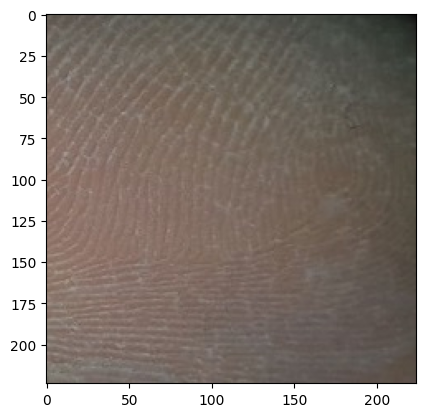

1/1 [==============================] - 1s 1s/step


In [20]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Healthy/image (1).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [21]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


(-0.5, 223.5, 223.5, -0.5)

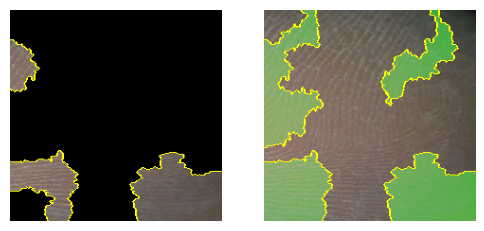

In [22]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

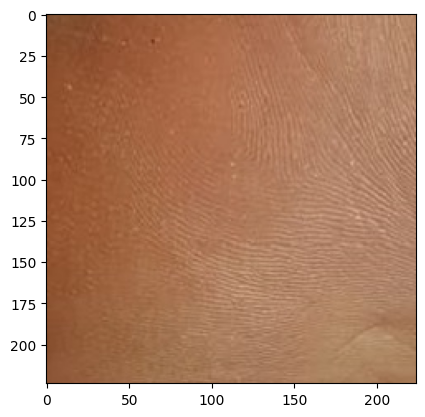

1/1 [==============================] - 0s 22ms/step


In [27]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Healthy/image (110).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [28]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


(-0.5, 223.5, 223.5, -0.5)

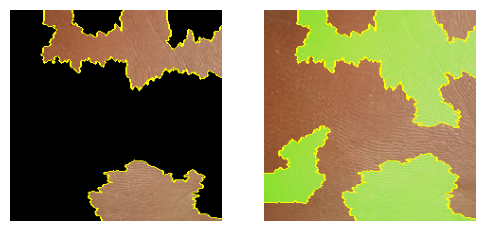

In [29]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

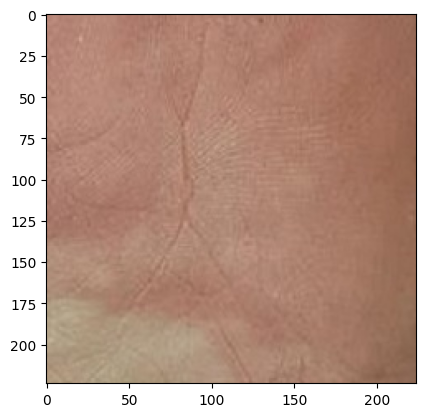

1/1 [==============================] - 0s 82ms/step


In [30]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Healthy/image (109).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [31]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


(-0.5, 223.5, 223.5, -0.5)

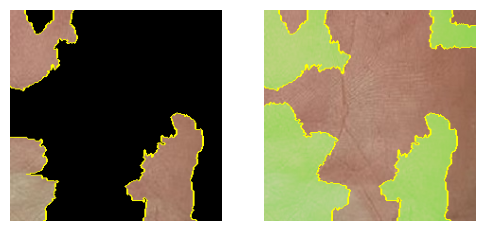

In [32]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

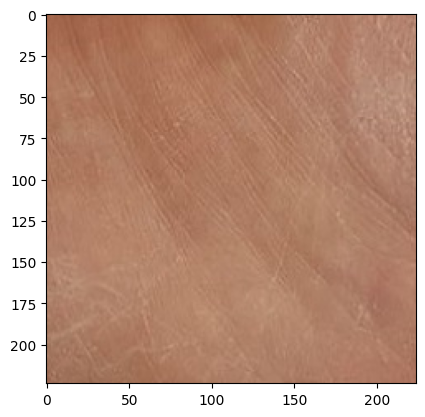

1/1 [==============================] - 0s 34ms/step


In [33]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Healthy/image (106).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [34]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


(-0.5, 223.5, 223.5, -0.5)

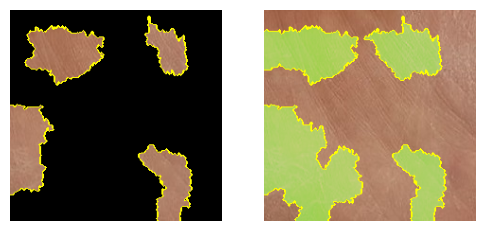

In [35]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

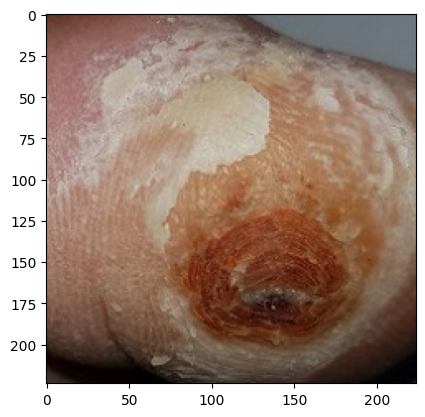

1/1 [==============================] - 0s 28ms/step


In [39]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (89).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [40]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


(-0.5, 223.5, 223.5, -0.5)

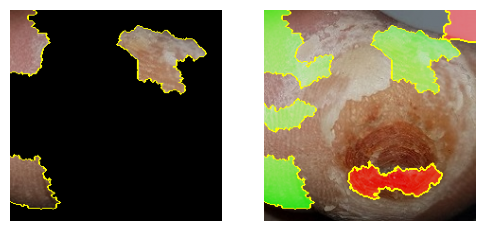

In [41]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

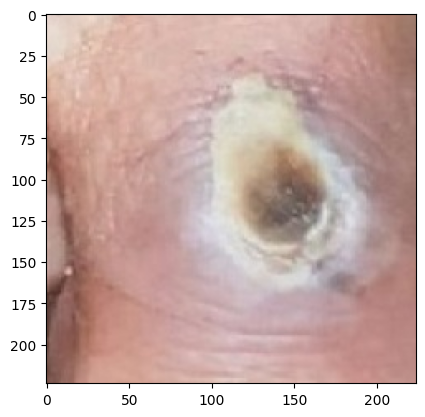

1/1 [==============================] - 0s 24ms/step


In [42]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (7).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [43]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


(-0.5, 223.5, 223.5, -0.5)

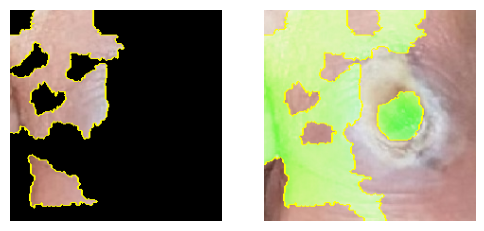

In [44]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

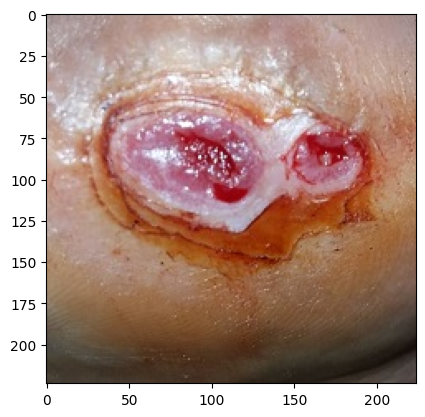

1/1 [==============================] - 0s 23ms/step


In [45]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (10).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [46]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


(-0.5, 223.5, 223.5, -0.5)

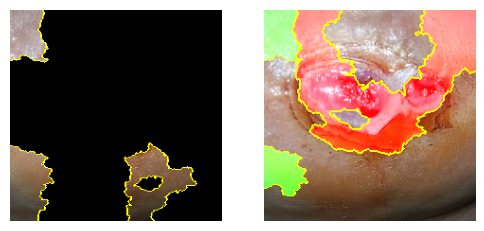

In [47]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

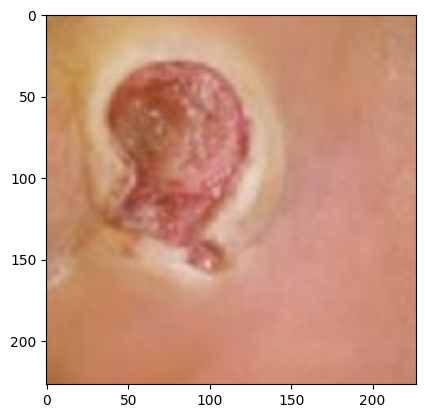

1/1 [==============================] - 0s 30ms/step


In [57]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (19).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [58]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


(-0.5, 223.5, 223.5, -0.5)

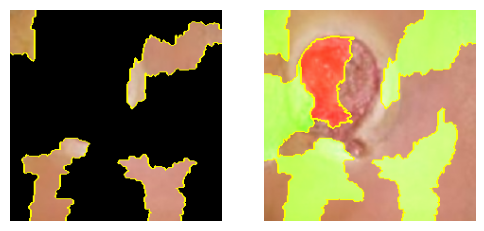

In [59]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

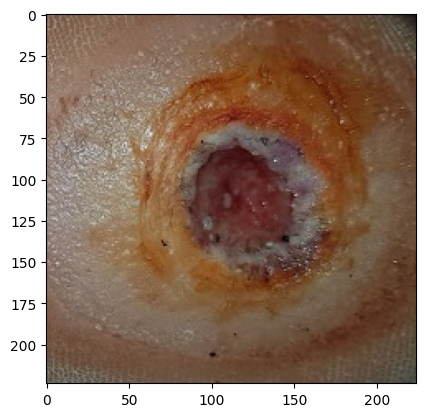

1/1 [==============================] - 0s 97ms/step


In [60]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (21).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [61]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


(-0.5, 223.5, 223.5, -0.5)

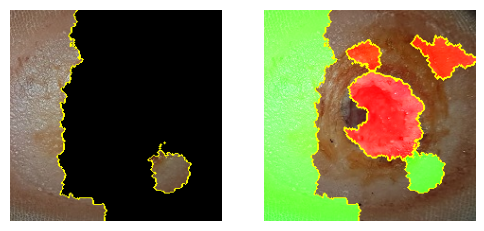

In [62]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')

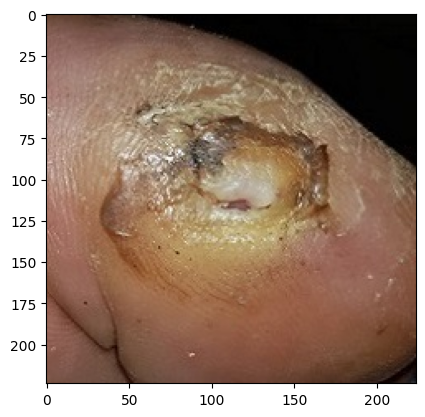

1/1 [==============================] - 0s 35ms/step


In [81]:
from tensorflow.keras.preprocessing import image
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (92).jpg")
def read_and_transform_img(image):
  img = np.array(image)
  img=resize(img,(224,224))
  img=np.expand_dims(img,axis=0)
  plt.imshow(image)
  plt.show()
  return img

images=read_and_transform_img(image)
preds=model.predict(images)
prediction=np.argmax(preds)
pct=np.max(preds)

In [82]:
explanation = explainer.explain_instance(images[0].astype('double'), #the image
                                         model.predict,
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=1000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


(-0.5, 223.5, 223.5, -0.5)

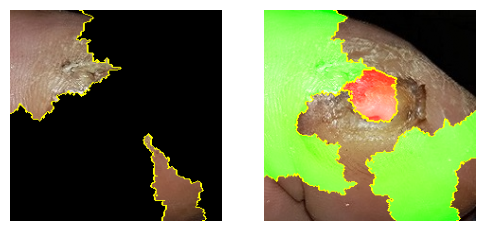

In [83]:
# maps for the first class predicted
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# plot image and mask together
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(6,5))
ax1.imshow(mark_boundaries(temp_1,mask_1))
ax2.imshow(mark_boundaries(temp_2,mask_2))
ax1.axis('off')
ax2.axis('off')